# Bento tutorial

**Author**: Clarence Mah | **Last Updated**: 3/18/2023

Here we will analyze the U2-OS cell dataset from the Bento paper, in which 130 genes are spatially profiled with MERFISH. The dataset here consists of 1153 cells, each with cell/nuclear segmentation masks and 2D transcript coordinates. Here we demonstrate Bento's key subcellular analyses of spatial transcriptomics data.

## Setup

Load libraries and configure paths.

In [1]:
import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

# Path to save figures
figdir = "Desktop/bento-manuscript-pub/bento-manuscript-pub/figures"

## Load Data

Bento includes access to datasets with the package. Datasets are downloaded and stored in `data_home`, which by default is set to `~/bento-data`.

The loaded object is an `AnnData` object, structured similarly to single-cell omics analysis, where observations are cells, features are genes, and the main matrix is an expression count matrix. Bento additionally stores molecular coordinates in `uns['points']` and polygons as columns in `obs`. 

```{note}
See the docs on Bento [data structures](../howitworks) for more details.
```

In [2]:
dataset = "merfish"
adata = bt.ds.load_dataset(dataset)
adata

AnnData object with n_obs × n_vars = 1153 × 135
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points'
    layers: 'spliced', 'unspliced'

Let's visualize RNA distributions using `bt.pl.density()`.

```{seealso}
See the [data visualization tutorial](data_visualization) for a more comprehensive guide on plotting.
```

```{note}
In general, plotting in `bento-tools` assumes datasets will have data stored from multiple fields of view (fov), which must be encoded in `adata.obs["batch"]`. The plotting functions plot a single fov at a time, which can be set with the `batch` parameter; if unspecified, the default is inferred from the first cell in `adata`.

If available, cell and nuclear shapes are plotted by default. Show additional shapes by passing them in a list to the `shapes` parameter.
```

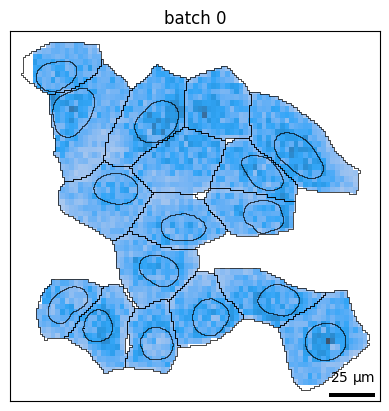

In [3]:
bt.pl.density(adata)

Or visualize a specific gene of interest with `bt.pl.points()`.

```{tip}
Plotting multiple genes can get slow quickly due to plotting the legend; if all you need is a visual, you can set `legend=False` and the plot should render more quickly.
```

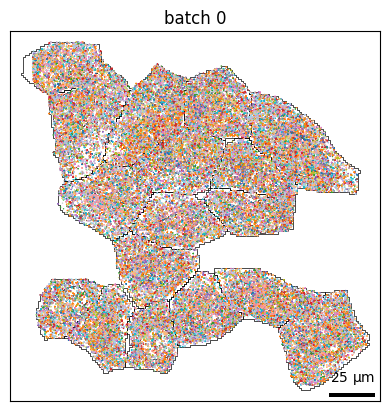

In [4]:
bt.pl.points(adata, hue="gene", legend=False, s=1, palette="tab20")

Let's filter out cells without a nucleus. There are several reasons why this may occur including missing segmentation, overlapping nuclei, or disagreement with cell segmentation. Accurate cell segmentation is a difficult task, especially in samples with high cell density (cells can overlap) and tissue sections.

In [5]:
adata = adata[adata.obs["nucleus_shape"] != None]
bt.ut.sync(adata)
adata

AnnData object with n_obs × n_vars = 1022 × 135
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points', 'point_sets'
    layers: 'spliced', 'unspliced'

Keep genes where at least 10 molecules are detected in at least one cell

In [6]:
gene_filter = (adata.X >= 10).sum(axis=0) > 0
adata = adata[:, gene_filter]
bt.ut.sync(adata)
adata

AnnData object with n_obs × n_vars = 1022 × 135
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points', 'point_sets'
    layers: 'spliced', 'unspliced'

## Spatial summary statistics

You can get a quick summary of cell and nuclear properties, including area, shape i.e. aspect ratio, and RNA density.

```{seealso}
See the [spatial features tutorial](Spatial-Features) for additional features and how to implement custom ones.
```

In [7]:
bt.tl.obs_stats(adata)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved to Desktop/bento-manuscript-pub/bento-manuscript-pub/figures/merfish_obs_stats.pdf


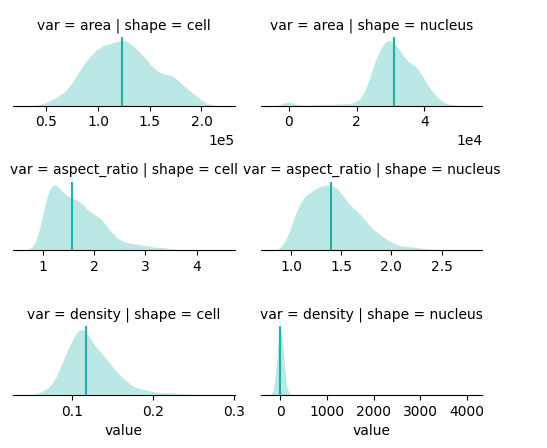

In [10]:
bt.pl.obs_stats(adata, fname=f"{figdir}/{dataset}_obs_stats.pdf")

## Predict RNA Localization Patterns

We will use the RNAforest model, to predict and annotate subcellular localization patterns. A single "sample" refers to the set of points corresponding to a given gene in a single cell. In the case that every cell expresses every gene, the number of samples is at most $n * m$ for $n$ cells and $m$ genes.

<img src="../_static/tutorial_img/rnaforest_workflow.png" alt="RNA Localization Pattern Annotation Workflow" width="800">

The five subcellular patterns we can predict are:

- **cell edge**: near the cell membrane
- **cytoplasmic**: mostly outside the nucleus in the cytoplasm
- **nuclear**: most in the nucleus
- **nuclear edge**: near the nuclear membrane, either
- **none**: none of the above patterns, more or less randomly distributed

```{seemore}
See [more details about the spatial statistics](../howitworks#spatial-features) used as input features for classification.
```

```{note}
Runtime: 90 minutes
```

In [ ]:
bt.tl.lp(adata)

Crunching shape features...


AnnData object modified:
    obs:
        + cell_span, cell_raster, cell_maxx, cell_miny, cell_radius, cell_minx, cell_maxy
    uns:
        + lp, lpp, cell_gene_features, cell_raster


We can view the observed pattern frequencies to get a rough idea of how transcripts are localizing.

In [ ]:
bt.pl.lp_dist(adata, percentage=True)

We can also visualize the localization of each gene where the point position denotes the balance between subcellular localization pattern frequencies. The color denotes the gene's most frequent pattern. Interestingly, we see a wide range of variability in localization. A large number of genes are pulled towards none while nuclear enriched genes show strong bias and a high fraction of cells.

In [ ]:
bt.tl.lp_stats(adata)

In [ ]:
bt.pl.lp_genes(
    adata,
    sizes=(10, 85),
    size_norm=(90, 100),
    fname=f"{figdir}/{dataset}_lp_genes.pdf",
)